In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors
import glob

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union

import hoomd
import gsd.hoomd

import sys
import time
import pickle
import gc
import pathlib
import os

import signac

from scipy import optimize

os.environ["POLARS_MAX_THREADS"] = "8"
import polars as pl

In [2]:
from monk import nb, prep, pair, render, utils, grid, workflow
import freud

parent = pathlib.Path(os.getcwd()).parent / "config.yaml"
config = workflow.get_config(parent.as_posix())

In [3]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'avail_seed': 11, 'dt': 0.005, 'step_unit': 1000, 'temp_steps': 20, 'equil_time': 40, 'run_time': 10, 'max_alpha_time': 1000, 'alpha_iters': 10, '_status': {}}

In [4]:
for i, job in enumerate(project):

    print(i, job, job.sp["pot"])
    files = glob.glob(job.fn("fixed-fine-equil/*.gsd"))
    for file in sorted(files):
        print(file)
    print()

0 a03bdc2a5be70a1e699a3f825fb8877b KA_LJ
/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/fixed-fine-equil/equil_temp-0.300.gsd
/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/fixed-fine-equil/equil_temp-0.337.gsd
/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/fixed-fine-equil/equil_temp-0.375.gsd
/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/fixed-fine-equil/equil_temp-0.412.gsd
/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/fixed-fine-equil/equil_temp-0.450.gsd
/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/fixed-fine-equil/equil_temp-0.487.gsd
/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/fixed-fine-equil/equil_temp-0.525.gsd
/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/fixed-fine-equil/equil_temp-0.562.gsd
/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/fixed-f

0 a03bdc2a5be70a1e699a3f825fb8877b KA_LJ


Text(0.5, 0, '$p_{hop}$')

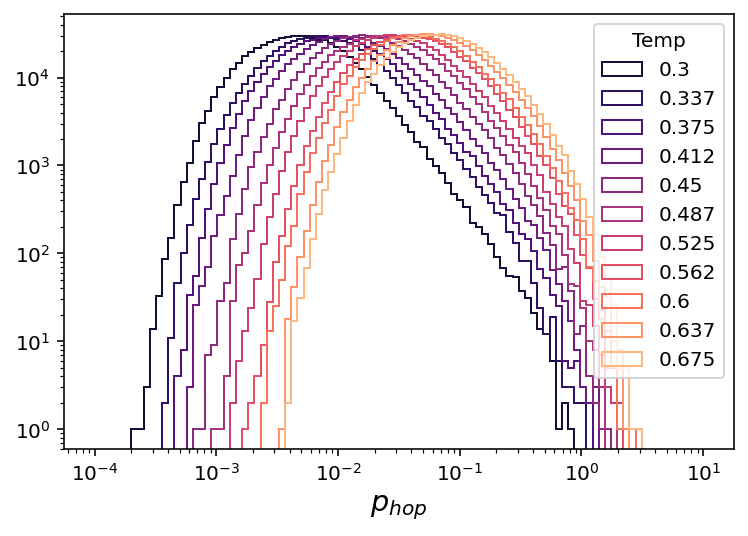

In [5]:
plt.figure()

cmap = cm.magma
norm = colors.Normalize(vmin=0.25, vmax=0.75)

bins = np.geomspace(1e-4, 1e1, 100)

for i, job in enumerate(project):

    print(i, job, job.sp["pot"])
    files = glob.glob(job.fn("fixed-analysis/*.parquet"))
    for file in sorted(files):
        temp = float(file.split("/")[-1].split("-")[-1].split(".parquet")[0])
        df = pd.read_parquet(file)
        plt.hist(df["phop"], label=temp, bins=bins, histtype="step", color=cmap(norm(temp)))
    break

plt.legend(title="Temp")
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$p_{hop}$", size="x-large")

In [9]:
sorted(files, key=lambda x: float(x.split("/")[-1].split("temp-")[-1].split(".parquet")[0]))

['/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/fixed-analysis/analysis-sfs_temp-0.300.parquet',
 '/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/fixed-analysis/analysis-sfs_temp-0.337.parquet',
 '/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/fixed-analysis/analysis-sfs_temp-0.375.parquet',
 '/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/fixed-analysis/analysis-sfs_temp-0.412.parquet',
 '/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/fixed-analysis/analysis-sfs_temp-0.450.parquet',
 '/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/fixed-analysis/analysis-sfs_temp-0.487.parquet',
 '/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/fixed-analysis/analysis-sfs_temp-0.525.parquet',
 '/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/fixed-analysis/analysis-sfs_temp-0.562.parquet',
 '/media/ian/Dat

0 a03bdc2a5be70a1e699a3f825fb8877b KA_LJ


1 1961d54ebec38ae1cebeabd263ddba5b KA_LJ
3 503e0376bd64085f1c22ed91ae48db88 KA_LJ
4 b579e52b6ab959f8f7d04ba6af76a9be KA_LJ
5 a82cc8d96904a27f96a31c3ee6bd0deb KA_LJ
6 127b38ea46bce9a180ac54e7adf90bf5 KA_LJ
7 eb25523e79e0f62b126ad67ec75f5ca7 KA_LJ
8 195c4fa433b01286ebe2ce7c821cb9e1 KA_LJ
9 7f2847dfac7ec1375318bf516d01123f KA_LJ
10 a0f72fa2c65b6e380a9e3b21848079ed KA_LJ


Text(0.5, 0, '$T$')

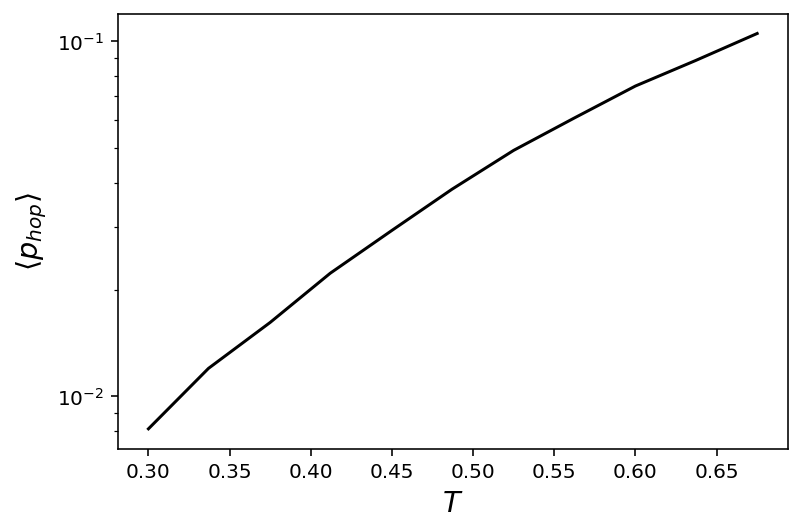

In [11]:
plt.figure()

cmap = cm.magma
norm = colors.Normalize(vmin=0.25, vmax=0.75)

xs = []
ys = []

for i, job in enumerate(project):

    if "WCA" in job.sp["pot"]:
        continue

    print(i, job, job.sp["pot"])
    files = glob.glob(job.fn("fixed-analysis/*.parquet"))

    for file in sorted(files):
        temp = float(file.split("/")[-1].split("-")[-1].split(".parquet")[0])
        df = pl.read_parquet(file, parallel=True, use_pyarrow=True)
        xs.append(temp)
        ys.append(df["phop"].mean())
    
tdf = pd.DataFrame({"T": xs, "phop": ys})
nxs = []
nys = []
for x, ttdf in tdf.groupby("T"):
    nxs.append(x)
    nys.append(ttdf["phop"].mean())

plt.plot(nxs, nys, color="k")

plt.yscale("log")
plt.ylabel(r"$\langle p_{hop} \rangle$", size="x-large")
plt.xlabel(r"$T$", size="x-large")

0 a03bdc2a5be70a1e699a3f825fb8877b KA_LJ
1 1961d54ebec38ae1cebeabd263ddba5b KA_LJ
3 503e0376bd64085f1c22ed91ae48db88 KA_LJ
4 b579e52b6ab959f8f7d04ba6af76a9be KA_LJ
5 a82cc8d96904a27f96a31c3ee6bd0deb KA_LJ
6 127b38ea46bce9a180ac54e7adf90bf5 KA_LJ
7 eb25523e79e0f62b126ad67ec75f5ca7 KA_LJ
8 195c4fa433b01286ebe2ce7c821cb9e1 KA_LJ
9 7f2847dfac7ec1375318bf516d01123f KA_LJ
10 a0f72fa2c65b6e380a9e3b21848079ed KA_LJ


Text(0.5, 0, '$T$')

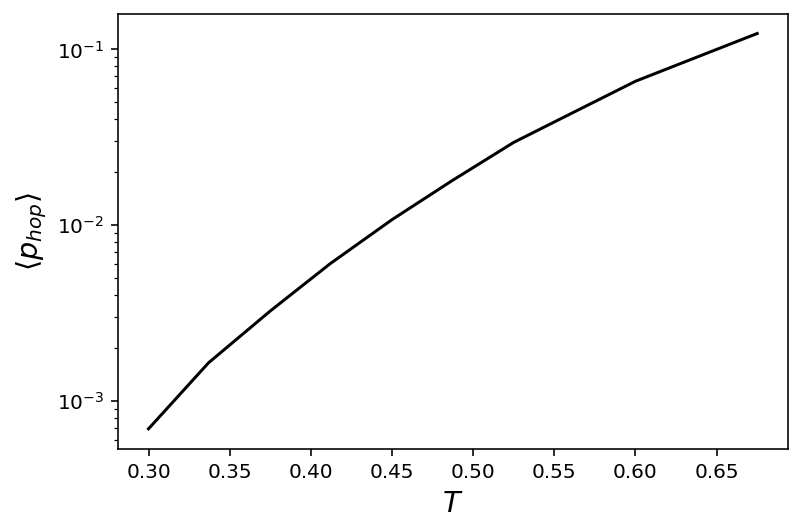

In [8]:
plt.figure()

cmap = cm.magma
norm = colors.Normalize(vmin=0.25, vmax=0.75)

xs = []
ys = []

for i, job in enumerate(project):

    if "WCA" in job.sp["pot"]:
        continue

    print(i, job, job.sp["pot"])
    files = glob.glob(job.fn("fixed-analysis/*.parquet"))

    for file in sorted(files):
        temp = float(file.split("/")[-1].split("-")[-1].split(".parquet")[0])
        df = pl.read_parquet(file, parallel=True, use_pyarrow=True)
        xs.append(temp)
        ys.append((df["phop"] > 0.2).mean())
    
tdf = pd.DataFrame({"T": xs, "phop": ys})
nxs = []
nys = []
for x, ttdf in tdf.groupby("T"):
    nxs.append(x)
    nys.append(ttdf["phop"].mean())

plt.plot(nxs, nys, color="k")

plt.yscale("log")
plt.ylabel(r"$P_R$", size="x-large")
plt.xlabel(r"$T$", size="x-large")

In [ ]:
plt.figure()

cmap = cm.magma
norm = colors.Normalize(vmin=0.25, vmax=0.75)

xs = []
ys = []

for i, job in enumerate(project):

    if "WCA" in job.sp["pot"]:
        continue

    print(i, job, job.sp["pot"])
    files = glob.glob(job.fn("fixed-analysis/*.parquet"))

    for file in sorted(files):
        temp = float(file.split("/")[-1].split("-")[-1].split(".parquet")[0])
        df = pl.read_parquet(file, parallel=True, use_pyarrow=True)
        xs.append(temp)
        ys.append((df["phop"] > 0.2).sum())
    
tdf = pd.DataFrame({"T": xs, "phop": ys})
nxs = []
nys = []
for x, ttdf in tdf.groupby("T"):
    nxs.append(x)
    nys.append(ttdf["phop"].mean())

plt.plot(nxs, nys, color="k")

plt.yscale("log")
plt.ylabel(r"$P_R$", size="x-large")
plt.xlabel(r"$T$", size="x-large")

In [9]:
print('POLARS_MAX_THREADS={}'.format(os.environ['POLARS_MAX_THREADS']))

POLARS_MAX_THREADS=8


In [27]:
df["phop"].describe()

count    589824.000000
mean          0.107414
std           0.118558
min           0.004008
25%           0.039416
50%           0.070369
75%           0.128932
max           2.828181
Name: phop, dtype: float64

In [6]:
print(file)

/media/ian/Data2/monk/2d-esl/workspace/a0f72fa2c65b6e380a9e3b21848079ed/fixed-analysis/analysis-sfs_temp-0.675.parquet


In [10]:
df = pl.read_parquet(file)

(array([5.64128e+05, 2.18520e+04, 2.97000e+03, 6.43000e+02, 1.77000e+02,
        3.50000e+01, 1.30000e+01, 4.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([3.16768093e-03, 3.28969985e-01, 6.54772282e-01, 9.80574548e-01,
        1.30637681e+00, 1.63217914e+00, 1.95798147e+00, 2.28378367e+00,
        2.60958600e+00, 2.93538833e+00, 3.26119065e+00]),
 <BarContainer object of 10 artists>)

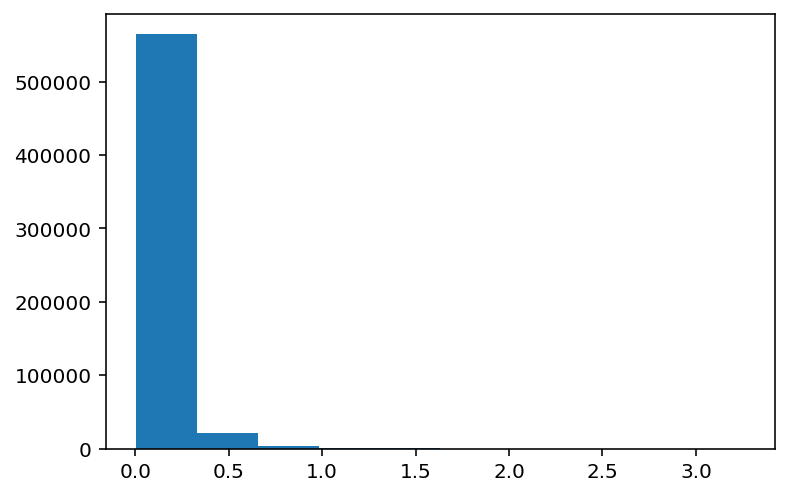

In [21]:
plt.hist(df["phop"])

In [20]:
for i, gdf in df.group_by("frame", maintain_order=True):
    # print(i)
    print(gdf.head())
    break

shape: (5, 5)
┌───────┬─────┬──────┬──────────┬────────────────────────┐
│ frame ┆ tag ┆ type ┆ phop     ┆ sf                     │
│ ---   ┆ --- ┆ ---  ┆ ---      ┆ ---                    │
│ u32   ┆ i64 ┆ u32  ┆ f32      ┆ list[f32]              │
╞═══════╪═════╪══════╪══════════╪════════════════════════╡
│ 0     ┆ 0   ┆ 0    ┆ 0.056545 ┆ [0.0, 0.0, … 1.138479] │
│ 0     ┆ 1   ┆ 0    ┆ 0.35106  ┆ [0.0, 0.0, … 1.317239] │
│ 0     ┆ 2   ┆ 0    ┆ 0.976745 ┆ [0.0, 0.0, … 3.247384] │
│ 0     ┆ 3   ┆ 1    ┆ 0.040847 ┆ [0.0, 0.0, … 0.763834] │
│ 0     ┆ 4   ┆ 1    ┆ 0.04866  ┆ [0.0, 0.0, … 0.374424] │
└───────┴─────┴──────┴──────────┴────────────────────────┘


In [5]:

soft = []
hard = []

for i, job in enumerate(project):

    if "WCA" in job.sp["pot"]:
        continue

    print(i, job.sp, job.sp["pot"])
    files = glob.glob(job.fn("fixed-analysis/*.parquet"))

    for file in sorted(files):
        temp = float(file.split("/")[-1].split("-")[-1].split(".parquet")[0])
        if temp != 0.337:
            continue
        print(temp)
        df = pl.read_parquet(file, parallel=True, use_pyarrow=True)
        soft_idx = df["phop"] > 0.2
        soft.append(df.filter(soft_idx))
        hard_idx = df["phop"] < 0.001
        hard.append(df.filter(hard_idx))
        # ys.append((df["phop"] > 0.2).mean())
        break
    # break



0 {'N': 32768, 'replica': 0, 'rho': 1.2, 'pot': 'KA_LJ'} KA_LJ
0.337


1 {'N': 32768, 'replica': 1, 'rho': 1.2, 'pot': 'KA_LJ'} KA_LJ
0.337
3 {'N': 32768, 'replica': 8, 'rho': 1.2, 'pot': 'KA_LJ'} KA_LJ
0.337
4 {'N': 32768, 'replica': 9, 'rho': 1.2, 'pot': 'KA_LJ'} KA_LJ
0.337
5 {'N': 32768, 'replica': 3, 'rho': 1.2, 'pot': 'KA_LJ'} KA_LJ
0.337
6 {'N': 32768, 'replica': 2, 'rho': 1.2, 'pot': 'KA_LJ'} KA_LJ
0.337
7 {'N': 32768, 'replica': 7, 'rho': 1.2, 'pot': 'KA_LJ'} KA_LJ
0.337
8 {'N': 32768, 'replica': 5, 'rho': 1.2, 'pot': 'KA_LJ'} KA_LJ
0.337
9 {'N': 32768, 'replica': 6, 'rho': 1.2, 'pot': 'KA_LJ'} KA_LJ
0.337
10 {'N': 32768, 'replica': 4, 'rho': 1.2, 'pot': 'KA_LJ'} KA_LJ
0.337


In [55]:
N = 5000
soft_df = pl.concat(soft)
print(soft_df.shape)
soft_df = soft_df.sample(N)
hard_df = pl.concat(hard)
print(hard_df.shape)
hard_df = hard_df.sample(N)
soft_df = soft_df.with_columns(
    y = 1
)
hard_df = hard_df.with_columns(
    y = 0
)

analysis_df = pl.concat([soft_df, hard_df])
# permute
# analysis_df = analysis_df.shuffle()
soft_df.shape, hard_df.shape

(9669, 5)
(43682, 5)


((5000, 6), (5000, 6))

In [56]:
analysis_df["y"].mean()

0.5

In [57]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [58]:
X = analysis_df["sf"].to_numpy()
y = analysis_df["y"].to_numpy()
# X, y
X, y = shuffle(X, y, random_state=0)

In [59]:
X = list(X)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
svc = LinearSVC(max_iter=10000)
svc.fit(X_train, y_train)

LinearSVC(max_iter=10000)

In [62]:
# get accuracy
from sklearn.metrics import accuracy_score
y_pred = svc.predict(X_test)
accuracy_score(y_test, y_pred)

0.762

In [63]:
y_train.mean()

0.49875

In [64]:
# get confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[772, 218],
       [258, 752]])

In [73]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler', scaler), ('svc', svc)])
y_pred_pipe = pipe.predict(scaler.inverse_transform(X_test))

In [75]:
(y_pred_pipe == y_pred).all()

True

In [76]:
with open("svc.pkl", "wb") as fp:
    pickle.dump(pipe, fp)